In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
import json
import matplotlib.pyplot as plt

def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))


def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))


def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')
current_liquidity_usd = 166.31 * 10**6

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
with open('gas_prices_final.json', 'r') as file:
    gas_price_eth = json.load(file)

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']

data['avg_block_gas'] = data['blockNumber'].astype(str).map(gas_price_eth)
data['avg_gas']    = data['gasUsed'] * data['avg_block_gas'].rolling(20).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - data['avg_gas'])*100 / data['amountUSD']

data['LVR_zscore'] = zscore(data['arb_pnl'])

data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['amount0'].apply(lambda x: (2*x + x**2)/current_liquidity_usd)*100/data['price_dex'])

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = (-np.sign(data['amount1']) * data['arb_fee']/100).clip(-0.1, 0.1)

data = data.dropna()

features = [#'LVR_nbtoken',
            #'price_diff', 
            #'arb_pnl', 
            'std',
            'price_impact',
            #'mean_rol_amount', 'avg_gas',  'rol_amountUSD',
            'lambda_1min',# 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min',# 'rol_5min_span', 'rol_5m_trade_count', 
            'amountUSD',
            ]
target = 'target_fee' # 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

# max and min fee in %
f_min = 0.02
f_max = 0.08

params = {}
for f in features:
    params[f] = {'lower_quantile': 0.1, 'upper_quantile': 0.9}
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.010468,1032.0,60.0,0.058140,1404.0,100.0,0.071225,-0.001895
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000007,1032.0,60.0,0.058140,1404.0,101.0,0.071937,0.100000
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.000003,1044.0,60.0,0.057471,1428.0,102.0,0.071429,0.099442
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000591,1056.0,60.0,0.056818,1476.0,103.0,0.069783,-0.006757
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000079,1080.0,60.0,0.055556,1500.0,104.0,0.069333,0.019911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.001369,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.007469
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.059305,1128.0,60.0,0.053191,4116.0,300.0,0.072886,-0.001129
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000264,1140.0,60.0,0.052632,4104.0,300.0,0.073099,-0.014507
187224,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,31966.914977,1.179945e+06,7.110914,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.000826


In [5]:
# Get the factor weightings
X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}
features_importance_normalized

{'std': 0.1760482019872396,
 'price_impact': 0.15584687052960985,
 'lambda_1min': 0.120098077195005,
 'lambda_5min': 0.14882953822331163,
 'amountUSD': 0.39917731206483387}

In [6]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:   
    low_q  = params[f]['lower_quantile']
    high_q = params[f]['upper_quantile']

    scale_min = data_filtered[f].quantile(high_q)
    scale_max = data_filtered[f].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)}) 

    if len(sell_subset[sell_subset[f]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[f]<0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]<0][f].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[f]>0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]>0][f].quantile(high_q)
        
    if len(buy_subset[buy_subset[f]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(high_q)

    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)
    
    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: buy_fee(x, f_min, f_max, w_buy))
    if data_filtered[f].min() >= 0:
        w_sell = w_sell.clip(0, 1)
        sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: sell_fee(-x, f_min, f_max, w_sell))
    else:
        sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: sell_fee(x, f_min, f_max, w_sell))
        
combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)/100

combined_data['selling_fee'] = 0 
combined_data['buying_fee']  = 0 

combined_data.loc[combined_data['amount0'] < 0, 'selling_fee'] = combined_data['combined_fee']
combined_data.loc[combined_data['amount1'] < 0, 'buying_fee'] = combined_data['combined_fee']

combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']



In [7]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'avg_gas'             : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'last',
    'selling_fee'         : 'last',
    'buying_fee'          : 'last',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()
metrics['std'] = metrics['close'].rolling(window=60).std()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'].abs() * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = (pool_fee_rate*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = ((1-pool_fee_rate)*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_5m'] = (metrics['cpnl_5m_negative'].abs() / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = (metrics['combined_fee'].abs()*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = ((1-metrics['combined_fee'].abs())*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_5m'] = (metrics['dpnl_5m_negative'].abs() / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_5m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_5m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-02 04:07:00,2382.996110,2384.187846,2382.996110,2384.187846,128495.257966,-53.882448,128447.632350,1.042154,-3.502038,2.534107,...,61.134163,641.749823,789.223732,74.410986,0.000000,-217.030189,-1.000277,0.000000,-217.025148,-1.000438
2024-01-02 04:08:00,2384.187846,2384.426265,2384.187846,2384.426265,13655.907425,-5.723961,17637.125998,-1.356265,-3.124062,0.031737,...,6.981325,650.568386,796.205057,70.274097,0.000000,-185.617682,-1.000093,0.000000,-185.623332,-1.000149
2024-01-02 04:09:00,2384.426265,2384.426265,2384.426265,2384.426265,14314.066634,-5.998290,24281.923516,-1.676265,9.722618,0.064675,...,9.638415,662.709347,805.843472,53.340393,0.004861,-153.405717,-1.000063,0.003859,-153.421036,-1.000097
2024-01-02 04:10:00,2384.426265,2384.426265,2384.426265,2384.426265,-5965.888120,2.503331,5965.619981,-0.676265,-1.692916,0.003940,...,3.979564,665.692157,810.061455,46.364139,0.004861,-121.218760,-1.000043,0.003859,-121.230913,-1.000060
2024-01-02 04:11:00,2384.426265,2384.426265,2384.187846,2384.187846,-21123.124665,8.863981,21550.944653,-1.117846,-8.016510,0.057365,...,8.731447,676.467630,818.554484,42.778559,0.004861,-16.327359,-1.000059,0.003859,-16.328274,-1.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 00:56:00,2341.424362,2341.424362,2341.190243,2341.424362,-33708.154083,14.406980,43471.757202,-1.394362,14.359031,0.265370,...,16.226887,22698.272236,30417.415538,14.446564,0.010293,-29.262578,-1.000427,0.008919,-29.256642,-1.000422
2024-01-31 00:57:00,2341.424362,2341.424362,2341.190243,2341.190243,-8005.330722,3.425778,29883.928378,0.489757,4.370169,0.070550,...,21.494940,22713.214200,30440.080723,15.240600,0.012478,0.000000,-0.857502,0.012233,0.000000,-0.857489
2024-01-31 00:58:00,2341.190243,2341.190243,2340.019999,2340.019999,-136075.169012,58.168866,142091.080821,-1.099999,-68.063091,2.533897,...,112.459584,22784.259741,30552.540307,23.196398,0.011824,-68.029059,-0.857450,0.011304,-68.009221,-0.857432


In [8]:
add_per = (metrics['dpnl'] - metrics['cpnl']).sum()/current_liquidity_usd
print('Additional profits of the dynamic fee over the constant fee model: ', round(add_per*100,2), '%')
print('')
price_impact_improvments = 1 - 1/(1+add_per)
print('Price impact of the dynamic fee model decreased by: ', round(price_impact_improvments*100,2), '%')
print('')
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] > 0]['combined_fee'].mean()*100
average_fee_negative = combined_data[combined_data['amount1'] < 0]['combined_fee'].mean()*100

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].abs().sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].abs().sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
# print('')
# print(f"The % of toxic pnl flow in constant fee: {round(((metrics['c%_toxic_flow_ma_5m'].abs()-1)*100).clip(-1,1).mean()*100,2)}")
# print(f"The % of toxic pnl flow in dynamic  fee: {round(((metrics['d%_toxic_flow_ma_5m'].abs()-1)*100).clip(-1,1).mean()*100,2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('The impermanent loss is : ', round(metrics['impermanent_loss'].sum()*100, 2))
print('Average tcost_usd     : ', round(metrics['tcost_usd'].mean(), 2))
print('')
weighted_fee = (combined_data['amountUSD'] * combined_data['combined_fee'].abs())/combined_data['amountUSD'].sum()
print('Average weighted_fee  : ', round(weighted_fee.mean()*100, 5))
print('Average selling_fee   : ', round(metrics['selling_fee'].abs().mean()*100, 2))
print('Average buying_fee    : ', round(metrics['buying_fee'].abs().mean()*100, 2))

weighted_buying_fee = ((combined_data[combined_data['amount1'] < 0]['buying_fee'] * combined_data[combined_data['amount1'] < 0]['amountUSD'])*100 / combined_data[combined_data['amount1'] < 0]['amountUSD'].sum()).sum()
weighted_selling_fee = ((combined_data[combined_data['amount1'] > 0]['selling_fee'] * combined_data[combined_data['amount1'] > 0]['amountUSD'])*100 / combined_data[combined_data['amount1'] > 0]['amountUSD'].sum()).sum()

print('Weighted average buying_fee: ', round(weighted_buying_fee, 2))
print('Weighted average selling_fee: ', round(weighted_selling_fee, 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['avg_gas'] + metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

Additional profits of the dynamic fee over the constant fee model:  0.0 %

Price impact of the dynamic fee model decreased by:  0.0 %

The average constant fees is: 0.05
The average dynamic selling fees is: -0.07
The average dynamic buying  fees is: 0.05

The total constant fees are: 22897.49
The total dynamic  fees are: 30707.1

The total pnl with c are: 22841.7
The total pnl with d are: 30629.81

The 1 min markout pnl is:  23390940.17
The impermanent loss is :  -0.0
Average tcost_usd     :  93.06

Average weighted_fee  :  0.0
Average selling_fee   :  0.05
Average buying_fee    :  0.02
Weighted average buying_fee:  0.06
Weighted average selling_fee:  -0.08
7.53% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  7.53


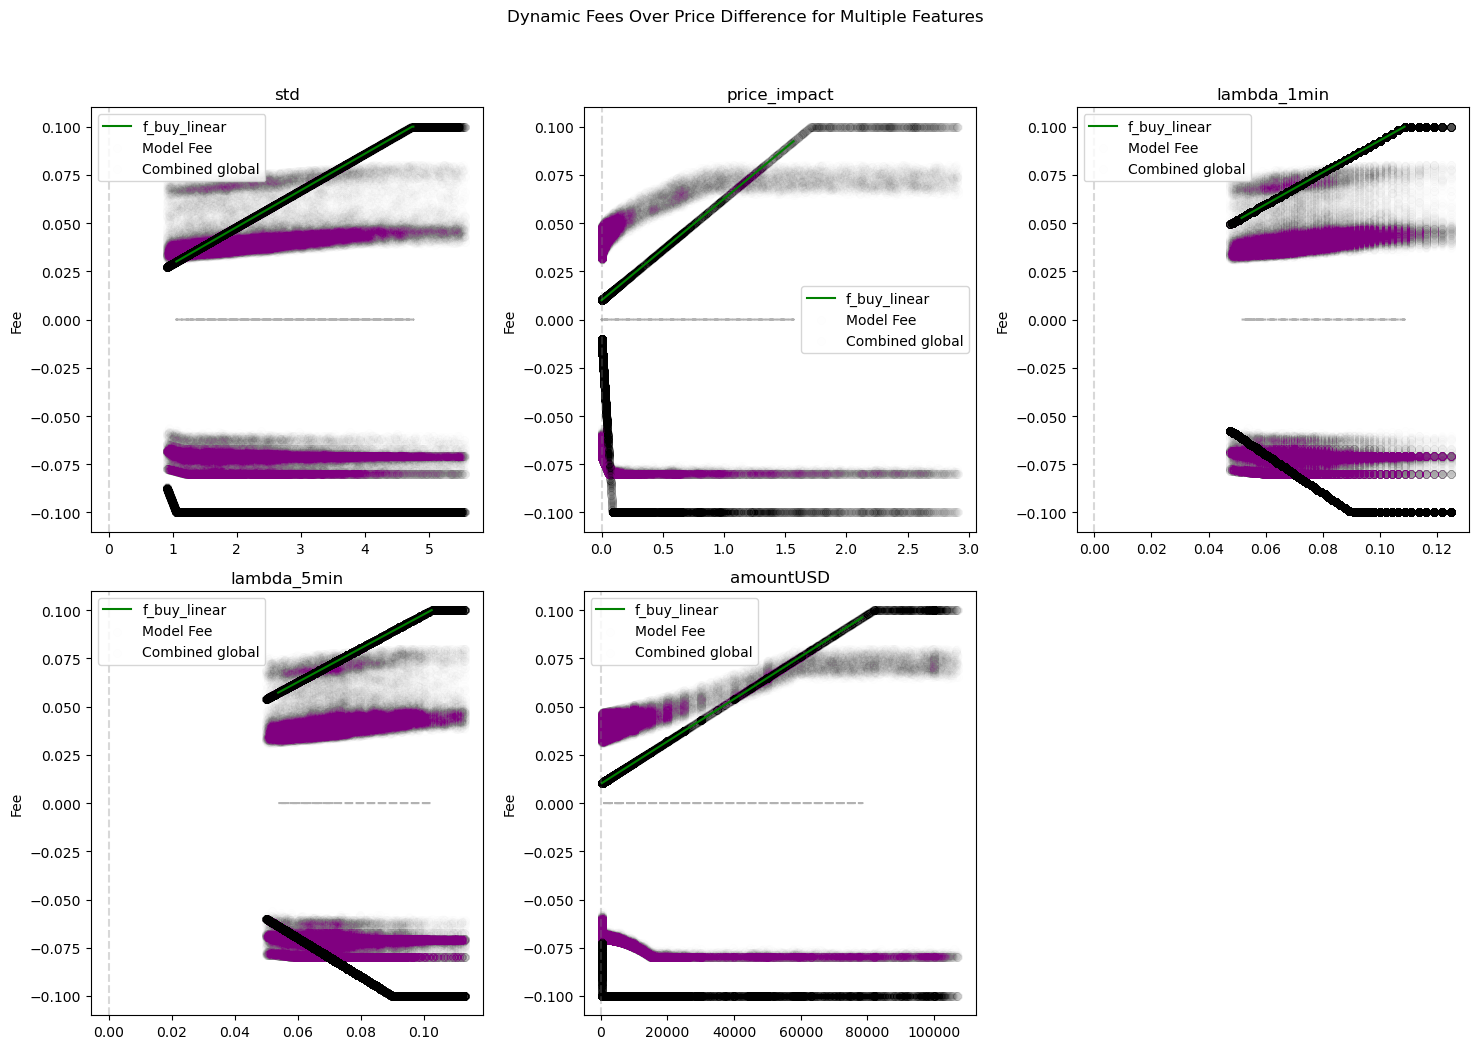

In [9]:
num_features = len(features)
cols = 3
rows = num_features // cols + (1 if num_features % cols > 0 else 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5 + 1))
fig.suptitle('Dynamic Fees Over Price Difference for Multiple Features')

f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95

for i, feat in enumerate(features):
    row, col = divmod(i, cols)
    
    # Adjust how to access the subplot axes based on the dimensionality of 'axs'
    if num_features > 1:
        if axs.ndim > 1:  # If 'axs' is two-dimensional
            ax = axs[row, col]
        else:  # If 'axs' is one-dimensional
            ax = axs[i]
    else:
        ax = axs 

    scale_min = data_filtered[feat].quantile(high_q)
    scale_max = data_filtered[feat].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

    # Segment the data based on 'amount1'
    buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
    sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

    if len(sell_subset[sell_subset[feat]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
        
    if len(buy_subset[buy_subset[feat]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)
    
    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

    # Apply the fees
    buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: buy_fee(x, f_min, f_max, w_buy))
    if data_filtered[feat].min() >= 0:
        # Adjust sell_subset model_fee calculation for features that are always positive
        w_sell = w_sell.clip(0, 1)
        sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: sell_fee(-x, f_min, f_max, w_sell))
        #ax.plot(delta_p['delta_p'], delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * max(0, x))), label='f_sell_linear', color='red')
    else:
        sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: sell_fee(x, f_min, f_max, w_sell))
        ax.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
        
    fus_data = pd.concat([buy_subset, sell_subset])

    # plot the fees and the model fee
    ax.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
    #ax.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
    
    filtered_plot = (fus_data[feat] >= fus_data[feat].quantile(low_q)) & (fus_data[feat] <= fus_data[feat].quantile(high_q))
    ax.scatter(fus_data[feat], fus_data['model_fee'], alpha=0.005, color='black', label='Model Fee')
    # ax.scatter(fus_data[filtered_plot][feat], fus_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')
    
    ax.scatter(combined_data[feat], combined_data['combined_fee']* 100, alpha=0.005, color='purple', label='Combined global')
    
    ax.plot(fus_data[filtered_plot][feat], [0]*len(fus_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3) 

    ax.set_ylabel('Fee')
    ax.legend(loc='best')
    ax.set_title(feat)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

In [15]:
# Adjusting bins to a higher value for finer granularity
metrics['fee_bucket'] = pd.cut(metrics['combined_fee'], bins=100)  # Adjusted number of bins from 10 to 20

# Calculate the average 'volumeUSD' for each bucket
agg_metrics = metrics.groupby('fee_bucket')[features].mean().reset_index()

In [18]:
agg_metrics

,fee_bucket,std,price_impact,lambda_1min,lambda_5min,volumeUSD
0,"(-0.000802, -0.000784]",4.395222,1.755280,0.082115,0.081820,104701.527203
1,"(-0.000784, -0.000768]",3.126641,1.772292,0.084843,0.079818,102844.743332
2,"(-0.000768, -0.000753]",3.985901,0.422316,0.080077,0.078318,43415.660618
3,"(-0.000753, -0.000737]",5.133952,0.645521,0.083670,0.082108,49909.244705
4,"(-0.000737, -0.000721]",4.237224,0.459832,0.083411,0.081374,37190.882003
...,...,...,...,...,...,...
95,"(0.000699, 0.000715]",4.607070,2.592992,0.078858,0.079430,125971.515137
96,"(0.000715, 0.000731]",3.752680,2.322670,0.076085,0.078263,115676.347470
97,"(0.000731, 0.000746]",4.901874,2.306685,0.078398,0.079405,111524.829024
98,"(0.000746, 0.000762]",3.565790,2.784543,0.093959,0.089954,123427.034151


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_54949/502217092.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), label='Average Arb PnL in %')


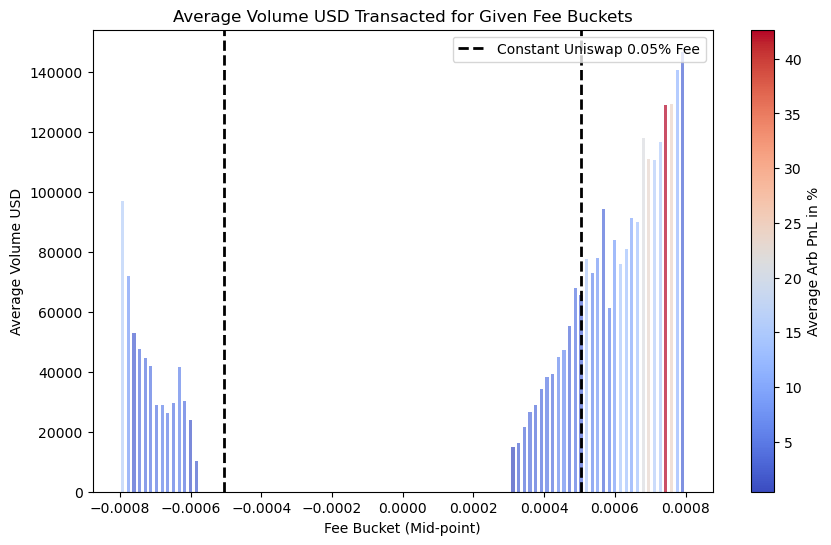

In [ ]:
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

# Adjusting bins to a higher value for finer granularity
metrics['fee_bucket'] = pd.cut(metrics['combined_fee'], bins=100)  # Adjusted number of bins from 10 to 20

features.remove('amountUSD')  # Removes 'amountUSD' from the list
features.append('volumeUSD')

# Calculate the average 'volumeUSD' for each bucket
agg_metrics = metrics.groupby('fee_bucket')[['volumeUSD','arb_pnl']].mean().reset_index()

# Convert intervals to mid-points for plotting
agg_metrics['fee_bucket_mid'] = agg_metrics['fee_bucket'].apply(lambda x: x.mid).astype(float)

arb_pnl_norm = Normalize(vmin=agg_metrics['arb_pnl'].abs().min(), vmax=agg_metrics['arb_pnl'].abs().max())
norm_arb_pnl = arb_pnl_norm(agg_metrics['arb_pnl'].abs())

colors = coolwarm(norm_arb_pnl)

plt.figure(figsize=(10, 6))

plt.bar(agg_metrics['fee_bucket_mid'], agg_metrics['volumeUSD'].astype('float'), alpha=0.7, color=colors, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)

plt.title('Average Volume USD Transacted for Given Fee Buckets')
plt.xlabel('Fee Bucket (Mid-point)')
plt.ylabel('Average Volume USD')
plt.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), label='Average Arb PnL in %')

closest_mid_point = agg_metrics['fee_bucket_mid'].sub(0.0005).abs().idxmin()
x_value_for_line = agg_metrics.loc[closest_mid_point, 'fee_bucket_mid']
plt.axvline(x=x_value_for_line, color='black', linestyle='--', linewidth=2, label='Constant Uniswap 0.05% Fee')
plt.axvline(x=-x_value_for_line, color='black', linestyle='--', linewidth=2)
plt.legend()

            
plt.show()

KeyError: 'arb_pnl'

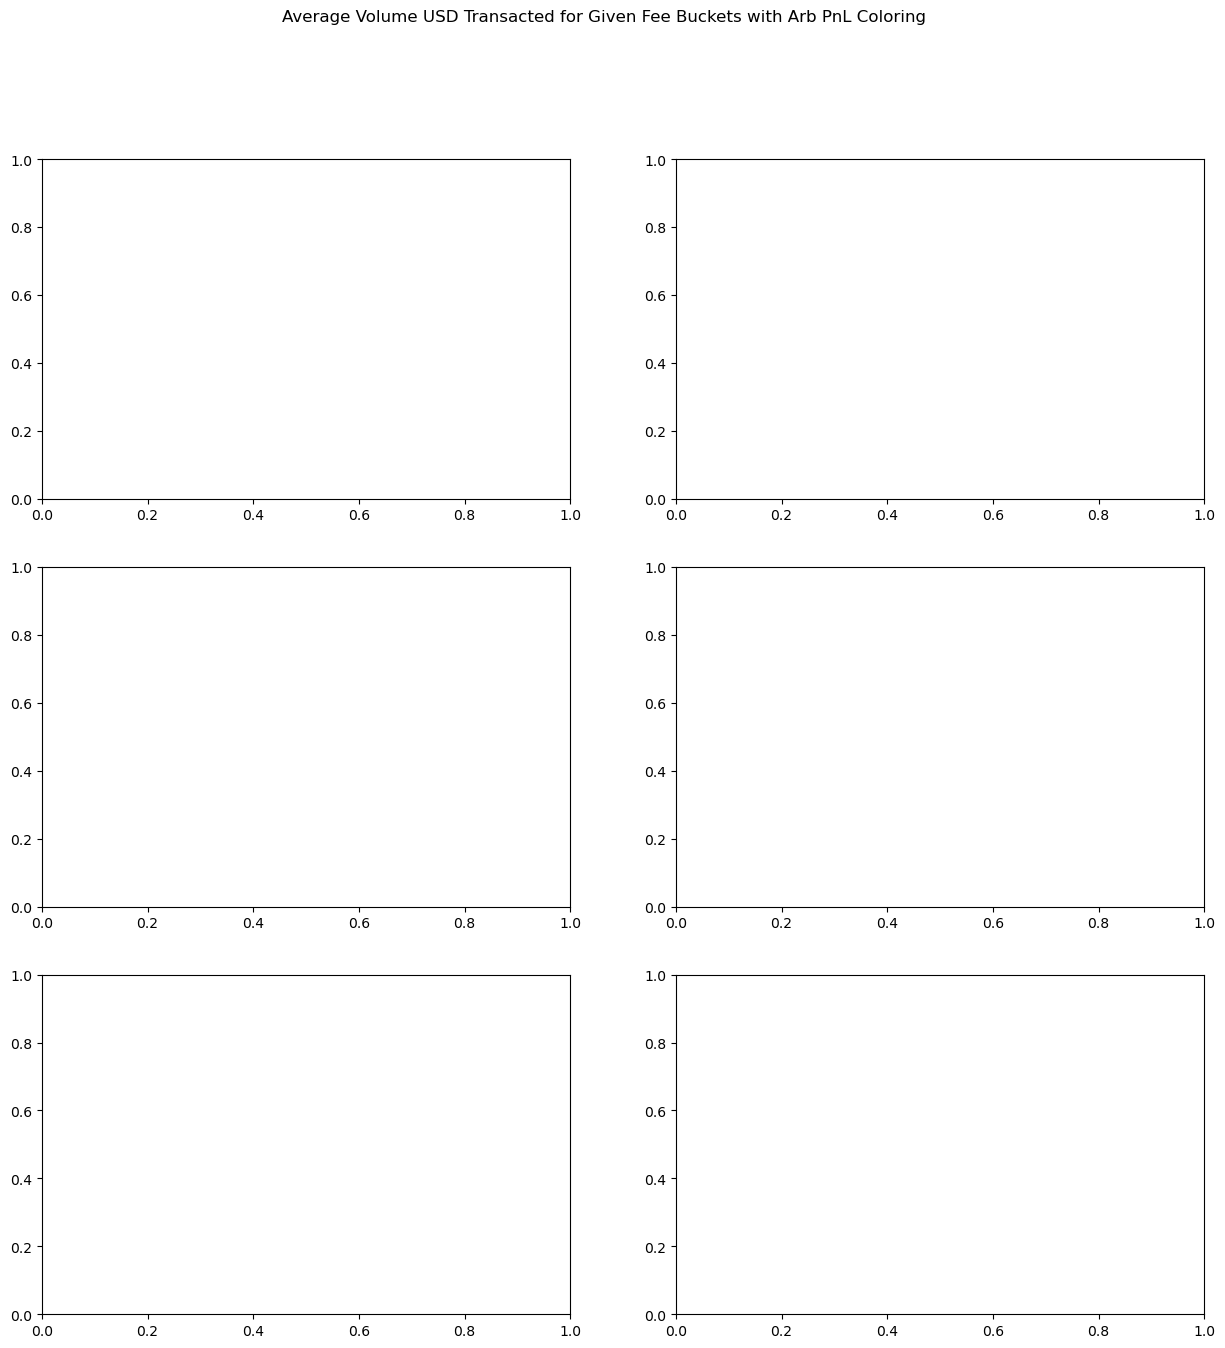

In [17]:
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

# Prepare the grid
num_features = len(features)
cols = 2  # Assuming you want 2 columns for a side-by-side comparison
rows = num_features // cols + (num_features % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
fig.suptitle('Average Volume USD Transacted for Given Fee Buckets with Arb PnL Coloring')

# Normalize 'arb_pnl' for coloring
arb_pnl_norm = Normalize(vmin=agg_metrics['arb_pnl'].abs().min(), vmax=agg_metrics['arb_pnl'].abs().max())
colors = coolwarm(arb_pnl_norm(agg_metrics['arb_pnl'].abs()))

# Plot each feature in its subplot
for i, feat in enumerate(features):
    ax = axs[i % rows, i // rows] if num_features > 1 else axs
    
    ax.bar(agg_metrics['fee_bucket_mid'], agg_metrics[feat], alpha=0.7, color=colors, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)
    
    # Add vertical lines for specific fee buckets
    closest_mid_point = agg_metrics['fee_bucket_mid'].sub(0.0005).abs().idxmin()
    x_value_for_line = agg_metrics.loc[closest_mid_point, 'fee_bucket_mid']
    ax.axvline(x=x_value_for_line, color='black', linestyle='--', linewidth=2, label='Constant Uniswap 0.05% Fee')
    ax.axvline(x=-x_value_for_line, color='black', linestyle='--', linewidth=2)  # If needed for symmetry
    
    ax.set_title(feat)
    ax.set_xlabel('Fee Bucket (Mid-point)')
    ax.set_ylabel('Average Volume USD')
    ax.legend()

# Add a colorbar to the last plot to explain the coloring scheme
fig.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), ax=axs, orientation='vertical', label='Average Arb PnL in %')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
